In [1]:
!pip install tld

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 6.9 MB/s eta 0:00:00


In [2]:
import re
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from urllib.parse import urlparse
from tld import get_tld, is_tld


# Load the dataset
df_orig = pd.read_csv('data/malicious_phish.csv')

In [3]:
df = df_orig.copy()
df['type'] = df['type'].apply(lambda x: 1 if x == 'benign' else 0)
df.head()

,url,type
0,br-icloud.com.br,0
1,mp3raid.com/music/krizz_kaliko.html,1
2,bopsecrets.org/rexroth/cr/1.htm,1
3,http://www.garage-pirenne.be/index.php?option=...,0
4,http://adventure-nicaragua.net/index.php?optio...,0


In [4]:
def train_random_forest(X_train, X_test, y_train, y_test, n_estimators=100, max_depth=20, use_vectorizor=True):
    # Extract features from the links using CountVectorizer
    if use_vectorizor:
      vectorizer = CountVectorizer()
      X_train = vectorizer.fit_transform(X_train)
      X_test = vectorizer.transform(X_test)

    # Create a random forest classifier
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

    # Train the model on the training data
    #print("Training...")
    clf.fit(X_train, y_train)

    # Evaluate the model on the testing data
    #print("Evaluating...")
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Return the trained model and accuracy
    return clf, accuracy

In [5]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['url'], df['type'], test_size=0.2, random_state=42)

In [6]:
clf, accuracy = train_random_forest(X_train, X_test, y_train, y_test)
print('Accuracy:', accuracy)

Accuracy: 0.8327588492642185


In [7]:
# Test each combination of hyperparameter values
def test_hyperparameters(X_train, X_test, y_train, y_test, n_estimators_values=50, max_depth_values=60, use_vectorizor=True):
  accuracy_scores = []
  for n_estimators in n_estimators_values:
      for max_depth in max_depth_values:
          print('Testing with n_estimators={}, max_depth={}'.format(n_estimators, max_depth))
          
          # Train and evaluate the random forest model
          clf, accuracy = train_random_forest(X_train, X_test, y_train, y_test, n_estimators=n_estimators, max_depth=max_depth, use_vectorizor=use_vectorizor)
          accuracy_scores.append(accuracy)

  # Plot the results in a heatmap
  accuracy_matrix = np.array(accuracy_scores).reshape(len(n_estimators_values), len(max_depth_values))
  sns.heatmap(accuracy_matrix, annot=True, xticklabels=max_depth_values, yticklabels=n_estimators_values)
  plt.xlabel('Max Depth')
  plt.ylabel('Number of Estimators')
  plt.title('Accuracy of Random Forest Model')
  plt.show()

Testing with n_estimators=50, max_depth=10
Testing with n_estimators=50, max_depth=20
Testing with n_estimators=50, max_depth=30
Testing with n_estimators=100, max_depth=10
Testing with n_estimators=100, max_depth=20
Testing with n_estimators=100, max_depth=30
Testing with n_estimators=150, max_depth=10
Testing with n_estimators=150, max_depth=20
Testing with n_estimators=150, max_depth=30


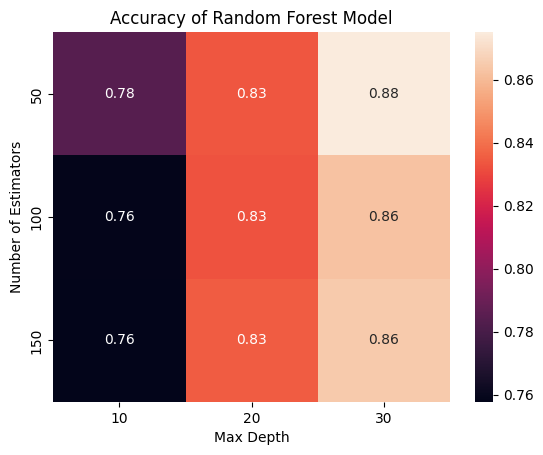

In [8]:
# Define the hyperparameter values to test
n_estimators_values = [50, 100, 150]
max_depth_values = [10, 20, 30]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['url'], df['type'], test_size=0.2, random_state=42)

test_hyperparameters(X_train, X_test, y_train, y_test, n_estimators_values, max_depth_values)

### Number of estimators does not have a serious impact on the model but max depth have

Testing with n_estimators=50, max_depth=30
Testing with n_estimators=50, max_depth=40
Testing with n_estimators=50, max_depth=50
Testing with n_estimators=50, max_depth=60
Testing with n_estimators=50, max_depth=70
Testing with n_estimators=50, max_depth=80
Testing with n_estimators=50, max_depth=90


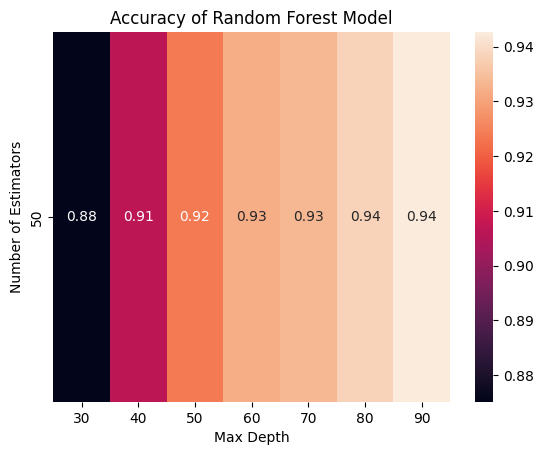

In [9]:
# Values for max_depth
n_estimators_values = [50]
max_depth_values = [30, 40, 50, 60, 70, 80, 90]
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['url'], df['type'], test_size=0.2, random_state=42)

test_hyperparameters(X_train, X_test, y_train, y_test, n_estimators_values, max_depth_values)

Currently, n_estimator = 50 and max_depth = 60

### Giving more featues from EDA stage 

In [10]:
def process_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
    
def having_ip_address(url):
    match = re.search(
        '(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.'
        '([01]?\d\d?|2[0-4]\d|25[0-5])\/)|'  # IPv4
        '(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.'
        '([01]?\d\d?|2[0-4]\d|25[0-5])\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [11]:
def preprocessing_urls(df):
  data = df.copy()
  data['url'] = data['url'].replace('www.', '', regex=True)
  data['url_len'] = data['url'].apply(lambda x: len(str(x)))
  data['domain'] = data['url'].apply(lambda i: process_tld(i))
  feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
  for a in feature:
      data[a] = data['url'].apply(lambda i: i.count(a))
  data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))
  data['digits']= data['url'].apply(lambda i: digit_count(i))
  data['letters']= data['url'].apply(lambda i: letter_count(i))
  data['Shortining_Service'] = data['url'].apply(lambda x: Shortining_Service(x))
  data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))
  return data

In [12]:
df = preprocessing_urls(df_orig)
df['type'] = df['type'].apply(lambda x: 1 if x == 'benign' else 0)
df.head()

,url,type,url_len,domain,@,?,-,=,.,#,...,$,!,*,",",//,abnormal_url,digits,letters,Shortining_Service,having_ip_address
0,br-icloud.com.br,0,16,br-icloud.com.br,0,0,1,0,2,0,...,0,0,0,0,0,0,0,13,0,0
1,mp3raid.com/music/krizz_kaliko.html,1,35,mp3raid.com,0,0,0,0,2,0,...,0,0,0,0,0,0,1,29,0,0
2,bopsecrets.org/rexroth/cr/1.htm,1,31,bopsecrets.org,0,0,0,0,2,0,...,0,0,0,0,0,0,1,25,0,0
3,http://garage-pirenne.be/index.php?option=com_...,0,84,garage-pirenne.be,0,1,1,4,2,0,...,0,0,0,0,1,1,7,60,0,0
4,http://adventure-nicaragua.net/index.php?optio...,0,235,adventure-nicaragua.net,0,1,1,3,2,0,...,0,0,0,0,1,1,22,199,0,0


In [13]:
features = ['url_len', '@', '?', '-', '=', '.', '#', '%',
       '+', '$', '!', '*', ',', '//', 'abnormal_url', 'digits', 'letters',
       'Shortining_Service', 'having_ip_address']

In [14]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df['type'], test_size=0.2, random_state=42)

Testing with n_estimators=50, max_depth=10
Testing with n_estimators=50, max_depth=20
Testing with n_estimators=50, max_depth=30
Testing with n_estimators=50, max_depth=40
Testing with n_estimators=100, max_depth=10
Testing with n_estimators=100, max_depth=20
Testing with n_estimators=100, max_depth=30
Testing with n_estimators=100, max_depth=40


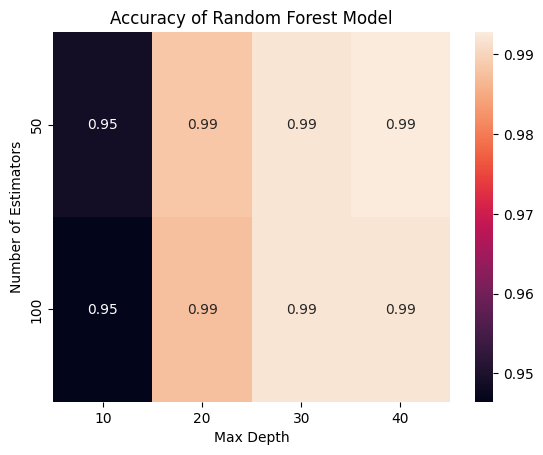

In [15]:
# Define the hyperparameter values to test
n_estimators_values = [50, 100]
max_depth_values = [10, 20, 30, 40]
test_hyperparameters(X_train, X_test, y_train, y_test, n_estimators_values, max_depth_values, False)

We achived 99% accuracy at number of estimators=50 and max depth=30 for binary classification



# Try for multi-class 

In [20]:
# Load the dataset again
df_orig = pd.read_csv('data/malicious_phish.csv')
df = df_orig.copy()
rem = {"Category": {"benign": 0, "defacement": 1, "phishing":2, "malware":3}}
df['Category'] = df['type']
df = df.replace(rem)
df = df.dropna()
df.head()

,url,type,Category
0,br-icloud.com.br,phishing,2.0
1,mp3raid.com/music/krizz_kaliko.html,benign,0.0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0.0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1.0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1.0


### Without Pre-processing

In [21]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['url'], df['Category'], test_size=0.2, random_state=42)

Testing with n_estimators=50, max_depth=30
Testing with n_estimators=50, max_depth=40
Testing with n_estimators=50, max_depth=50
Testing with n_estimators=50, max_depth=60
Testing with n_estimators=50, max_depth=70


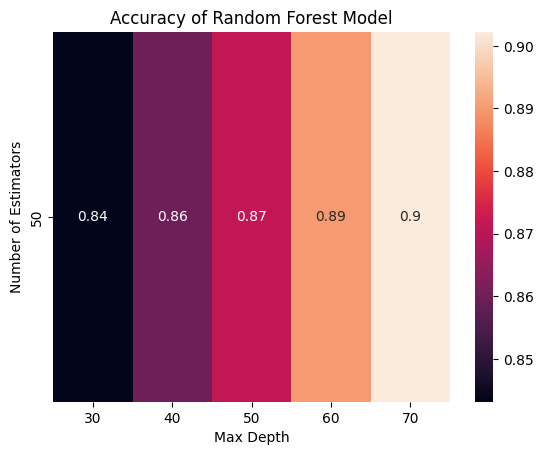

In [22]:
# Define the hyperparameter values to test
n_estimators_values = [50]
max_depth_values = [30, 40, 50, 60, 70]
test_hyperparameters(X_train, X_test, y_train, y_test, n_estimators_values, max_depth_values)

Accuracy saturated at max_depth=60




### With preprocessing

In [35]:
df = preprocessing_urls(df_orig)
rem = {"Category": {"benign": 0, "defacement": 1, "phishing":2, "malware":3}}
df['Category'] = df_orig['type']
df = df.replace(rem)
df = df.dropna()
df.head()

,url,type,url_len,domain,@,?,-,=,.,#,...,!,*,",",//,abnormal_url,digits,letters,Shortining_Service,having_ip_address,Category
0,br-icloud.com.br,phishing,16,br-icloud.com.br,0,0,1,0,2,0,...,0,0,0,0,0,0,13,0,0,2.0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,mp3raid.com,0,0,0,0,2,0,...,0,0,0,0,0,1,29,0,0,0.0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,bopsecrets.org,0,0,0,0,2,0,...,0,0,0,0,0,1,25,0,0,0.0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,84,garage-pirenne.be,0,1,1,4,2,0,...,0,0,0,1,1,7,60,0,0,1.0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,adventure-nicaragua.net,0,1,1,3,2,0,...,0,0,0,1,1,22,199,0,0,1.0


In [36]:
features = ['url_len', '@', '?', '-', '=', '.', '#', '%',
       '+', '$', '!', '*', ',', '//', 'abnormal_url', 'digits', 'letters',
       'Shortining_Service', 'having_ip_address']

In [37]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df['Category'], test_size=0.2, random_state=42)

Testing with n_estimators=50, max_depth=20
Testing with n_estimators=50, max_depth=30
Testing with n_estimators=50, max_depth=40
Testing with n_estimators=50, max_depth=50
Testing with n_estimators=100, max_depth=20
Testing with n_estimators=100, max_depth=30
Testing with n_estimators=100, max_depth=40
Testing with n_estimators=100, max_depth=50


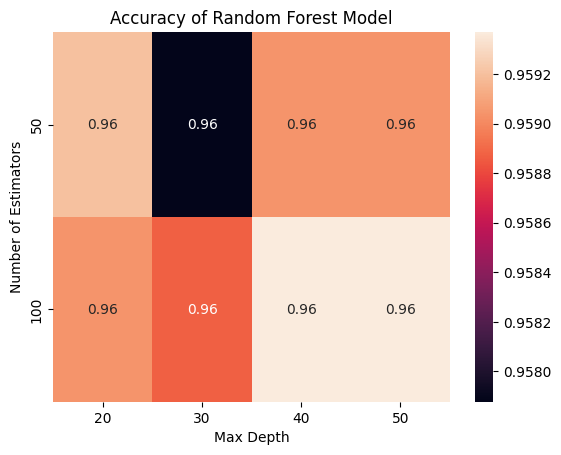

In [38]:
# Define the hyperparameter values to test
n_estimators_values = [50, 100]
max_depth_values = [20, 30, 40, 50]
test_hyperparameters(X_train, X_test, y_train, y_test, n_estimators_values, max_depth_values, False)

Achived 91% accuracy at n_estimators=50, max_depth=40 for multi-class